In [1]:
pip install -U neurodiffeq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from neurodiffeq.networks import FCNN # fully-connect neural network
import torch.nn as nn
from neurodiffeq.solvers import Solver1D

import numpy as np
import torch
from neurodiffeq.neurodiffeq import safe_diff as diff
from neurodiffeq.ode import solve, solve_system
from neurodiffeq.solvers import Solver1D
from neurodiffeq.monitors import Monitor1D
from neurodiffeq.conditions import IVP
import matplotlib.pyplot as plt

### Let's work with the damped harmonic oscilator, with the DE:

$$ m \ddot {x} + k \ell \dot {x} + mg \sin {\theta} = 0 $$

### If one need the angular movement, make the change:
$$ \dot {x} = \ell \dot {\theta} $$
$$ \ddot {x} = \ell \ddot {\theta} $$
### And the force
$$ m \ell \ddot {\theta} + k \ell \dot{\theta} + mg \sin {\theta} = F_d \cos {\omega_d t} $$

And We are solving this equation using $\textit{Neurodiffeq}$.

With the initial conditions

$$\omega(0)=\omega_0$$

$$\dot{\omega}(0)=\alpha_0$$


In [2]:
### Parameters
g = 10. # [m /s2]
l = 1. # [m]
m = 1. # [kg]
k = 5. # [kg /m /s]

Fd = 10 # [N]
wd = 10 # [2π /s]

w0 = np.pi # [rad]
alpha_0 = 0. # [rad /s]

#N = 200

#t = np.linspace(0., 10., N+1) # [s] an array of time steps


NameError: name 'np' is not defined

In [4]:
#DE
oscilator = lambda theta, t: [m*l*diff(theta, t, order=2) + k*l*diff(theta,t,order=1) + m*g*torch.sin(theta)-Fd*torch.cos(wd * t)]
init_conditions = [IVP(t_0=0.0, u_0=w0, u_0_prime=alpha_0)]

### Since the NN cant emulate the function, lets incrase the number of samples in every epoch:


In [8]:
from neurodiffeq.generators import Generator1D
from itertools import chain
from torch.optim import Adam

In [1]:
# specify the training set and validation set
ti=-0.1
tf=10

train_gen = Generator1D(size=32, t_min=ti, t_max=tf, method='uniform')
valid_gen = Generator1D(size=20, t_min=ti, t_max=tf, method='equally-spaced')

t=np.linspace(ti,tf,300)

NameError: name 'Generator1D' is not defined

In [10]:
# Specify the network architecture
architecture = [FCNN(hidden_units=(15,15), actv=nn.Tanh)]

In [11]:
# specify the optimizer
sgd_ho = Adam(
chain.from_iterable(n.parameters() for n in architecture), # this gives all parameters in
lr=0.1 # learning rate
#momentum=0.99, # momentum of SGD
)

In [102]:
#DE
oscilator = lambda theta, t: [m*l*diff(theta, t, order=2) + k*l*diff(theta,t,order=1) + m*g*theta-Fd*torch.cos(wd*t)]
init_conditions = [IVP(t_0=0.0, u_0=w0, u_0_prime=alpha_0)]

In [103]:
# specify the training set and validation set
ti=-0.1
tf=10

train_gen = Generator1D(size=1000, t_min=ti, t_max=tf, method='uniform')
valid_gen = Generator1D(size=1000, t_min=ti, t_max=tf, method='equally-spaced')


<IPython.core.display.Javascript object>


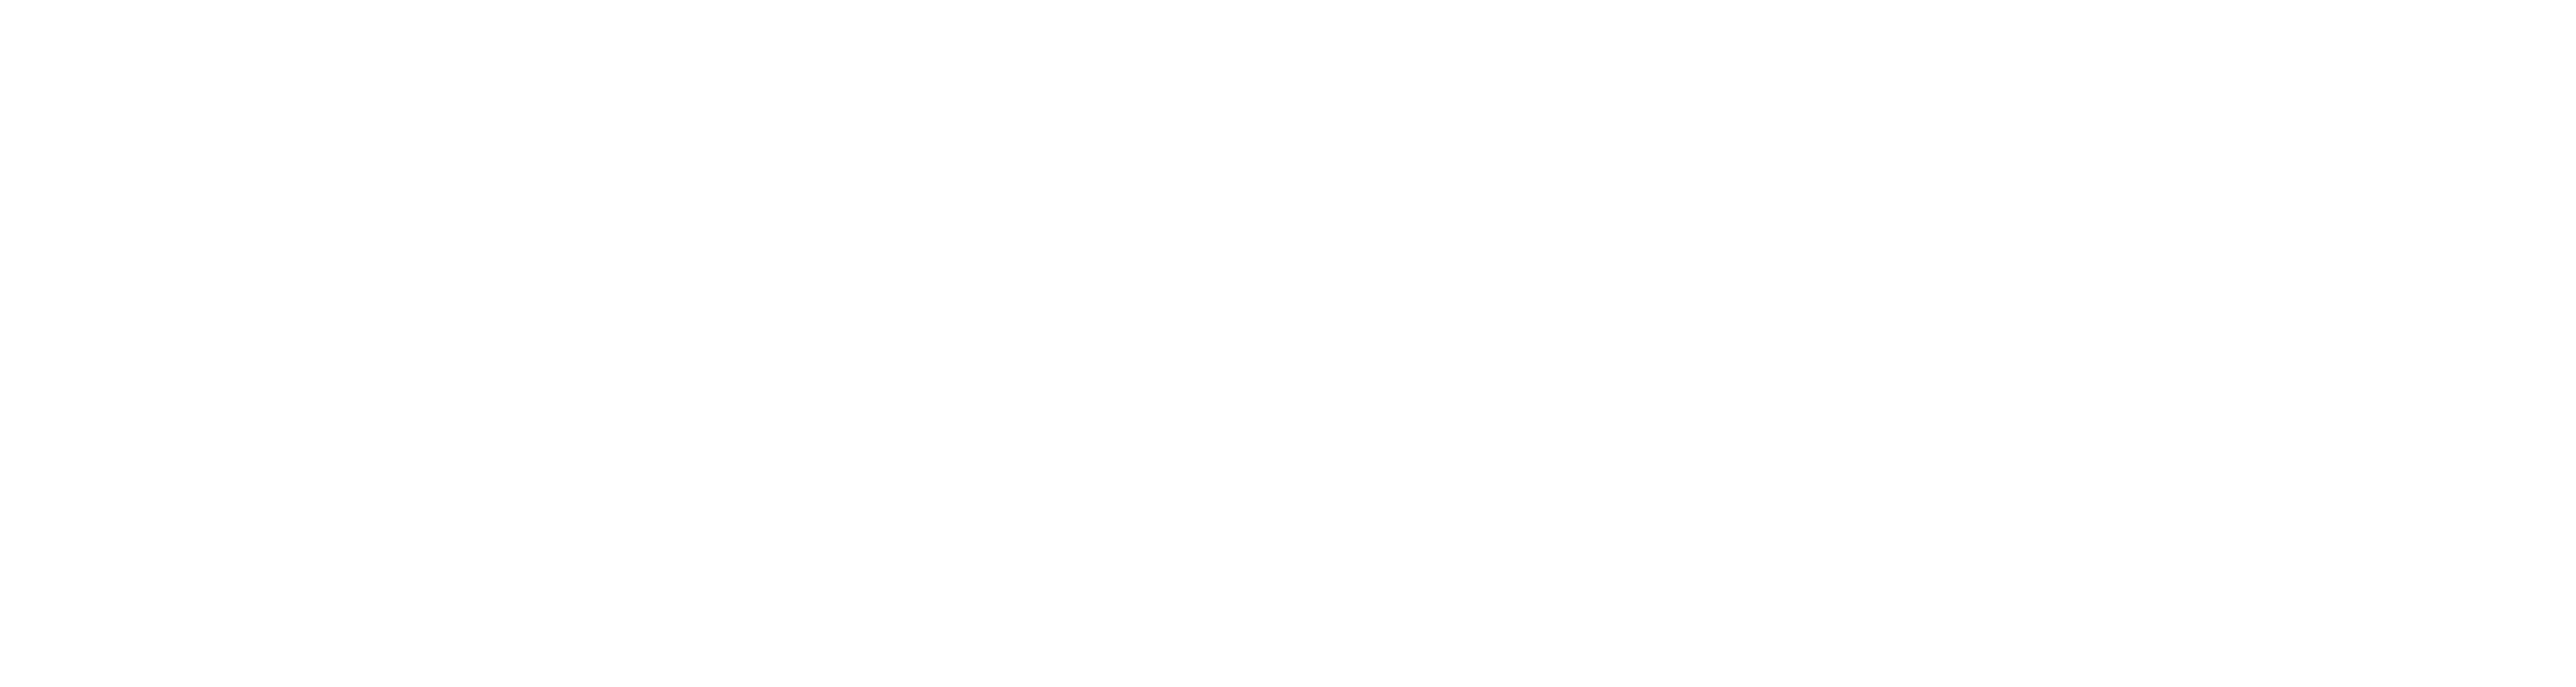

Training Progress:   0%|                                                                      | 0/5000 [00:00<…

KeyboardInterrupt: 

In [104]:
#Solving

#NN params
epochs=5000


# Specify the network architecture
architecture = [FCNN(hidden_units=(40, 40,40,40,40,40), actv=nn.Tanh)]
# Create a monitor callback
monitor_callback = Monitor1D(t_min=ti, t_max=tf, check_every=100).to_callback()
# Create a solver
solver = Solver1D(
ode_system=oscilator,
conditions=init_conditions,
t_min=ti,
t_max=tf,
train_generator=train_gen,
valid_generator=valid_gen,
nets=architecture,
)


#solver= solve(system, condition=init_conditions, t_min=ti, t_max=tf,
#max_epochs=epochs,net=net_ho)
# Fit the solver
solver.fit(max_epochs=epochs, callbacks=[monitor_callback])
# Obtain the solution
solutions = solver.get_solution()


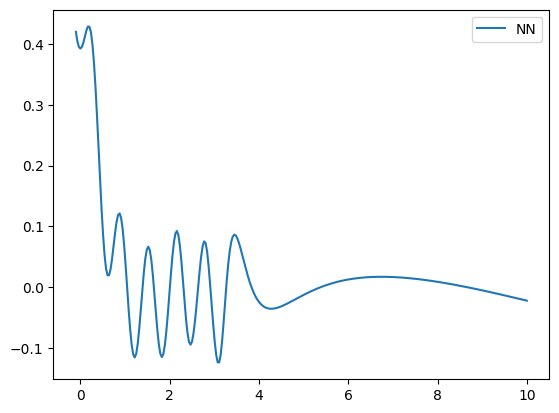

In [104]:
#plotting
t=np.linspace(ti,tf,300)
oscilador=solutions(t,to_numpy=True)

plt.plot(t,oscilador, label='NN')
#plt.plot(t,analitic(t), label='Analitic solution')
#plt.ylim(-0.05,0.05)
plt.legend()

# Vamos a comparar con odeint


In [105]:
def ode_int_rk(func, y_0, t, args={}):
    """Aproximación RK4 a un sistema de ecuaciones de primer orden (ODE) 
    con condiciones iniciales
    Args:
       func: el sistema de ecuaciones para aproximar
        y_0: (arreglo) condición inicial.
        t: (arreglo) Secuencia de puntos temporales para los que se va a resolver y.
            args: argumentos extra para la función

        Out:
            y: (arreglo) la solución aproximada del sistema en cada tiempo t,
                con el valor inicial de y_0 en la primer fila

    Out:
        y: (array) the approximated solution of the system at each time in t,
            with the initial value y_0 in the first row.
    """

    # Inicia el arreglo de las aproximaciones
    y = np.zeros([len(t), len(y_0)])
    y[0] = y_0

    # Loop a través de time steps, aproximando este step de los prev step
    for i, t_i in enumerate(t[:-1]):

        h = t[i+1] - t_i # tamaño  step

        k_1 = func(t_i, y[i], args)
        k_2 = func(t_i+h/2., y[i]+h/2.*k_1, args)
        k_3 = func(t_i+h/2., y[i]+h/2.*k_2, args)
        k_4 = func(t_i+h, y[i]+h*k_3, args)

        y[i+1] = y[i] + h/6.*(k_1 + 2.*k_2 + 2.*k_3 + k_4) # RK4 step

    return y

In [106]:
def pendulum(t, y, args):
    """ A damped and forced pendulum, described as set of two first-order ODEs.

    Args:
        t: Time
        y: Pendulum system vector [angle, angular velocity] 
        args['alpha']: gravity_acc/length_of_pendulum
        args['beta']: friction_constant/mass_pendulum
        args['gamma']: driving_force/mass_pendulum/length_pendulum
        args['omega']: driving_freq

    Returns:
        dydt: ODE vector
    """

    dydt = np.zeros(2)

    dydt[0] = y[1]
    dydt[1] = (-args['alpha']*y[0] - args['beta']*y[1] + 
                args['gamma']*np.cos(args['omega']*t))

    return dydt

In [107]:
### Parameters

gravity_acc = g # [m /s2]

length_pendulum = l# [m]
mass_pendulum = m # [kg]
friction_constant = k # [kg /m /s]

driving_force = Fd # [N]
driving_freq = wd # [2π /s]

N = 200

t = np.linspace(0., 10., N+1) # [s] an array of time steps

In [108]:
solve_args = {}
solve_args['alpha'] = gravity_acc/length_pendulum
solve_args['beta'] = friction_constant/mass_pendulum
solve_args['gamma'] = driving_force/mass_pendulum/length_pendulum
solve_args['omega'] = driving_freq

In [109]:
initial_ang = w0 # [rad]
initial_ang_vel = alpha_0 #[rad /s]

initial_cond = np.array([initial_ang, initial_ang_vel])

In [110]:
from scipy.integrate import odeint

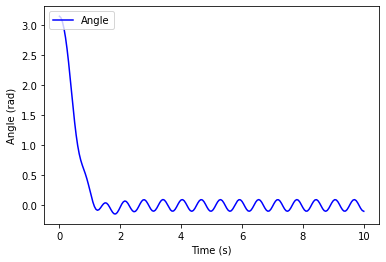

In [112]:
%matplotlib inline
# y = odeint(pendulum, initial_cond, t, args=(solve_args,))

# Solve Pendulum ODE with RK4
y = ode_int_rk(pendulum, initial_cond, t, solve_args)

y_small_ang = initial_ang*np.cos(np.sqrt(solve_args['alpha'])*t)

plt.plot(t, y[:,0], c='b', label='Angle')
#plt.plot(t, y_small_ang, 'r--', label='Small angle approx.')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.legend(loc=2)